In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

C:\Users\adeli\ProgramData\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Import Data

In [2]:
train_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\train.csv",parse_dates=['date'])
test_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\test.csv",parse_dates=['date']) 
holidays_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\holidays_events.csv",parse_dates=['date']) 
oil_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\oil.csv",parse_dates=['date']) 
stores_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\stores.csv")
transactions_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\transactions.csv",parse_dates=['date'])

### Missing Values Data

In [4]:
df = pd.concat([train_df, test_df], sort=True) #3029400
df = df.merge(oil_df, on='date', how='left')
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
index = ['store_nbr', 'family', 'date']

In [5]:
df.isnull().sum()

date                 0
family               0
id                   0
onpromotion          0
sales            28512
store_nbr            0
dcoilwtico      935550
city                 0
state                0
type                 0
cluster              0
transactions    274296
dtype: int64

In [6]:
complete_dates = df.date.unique()
df_oil_dates = pd.DataFrame(complete_dates)
df_oil_dates = df_oil_dates.rename(columns={0:'date'})

df_moving_avg_oil = df_oil_dates.merge(oil_df, on=['date'], how='left')
df_moving_avg_oil.dcoilwtico.bfill(axis ='rows', inplace=True)

df_moving_avg_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

C:\Users\adeli\AppData\Local\Temp\ipykernel_14580\59103484.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(


Text(0.5, 1.0, 'Oil Prices in Ecuador')

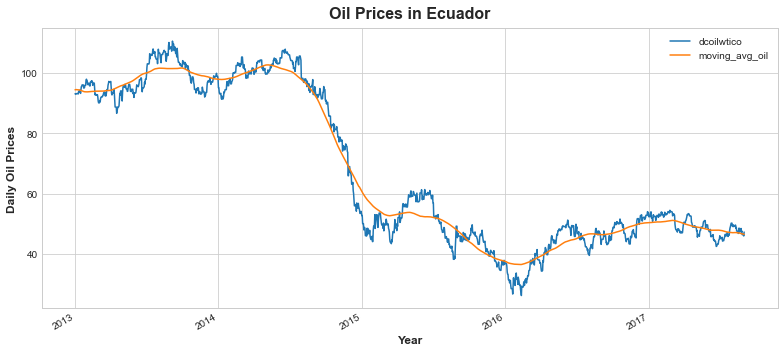

In [7]:
df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(
    window=180,       # Tested a couple window sizes to ensure bfill would result in zero null values
    center=True,      # puts the average at the center of the window
    min_periods=90,   # choose about half the window size
).mean()              # compute the mean

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

df_moving_avg_oil['Year'] = df_moving_avg_oil['date'].dt.year

df_moving_avg_oil.plot.line(x='date', y=['dcoilwtico', 'moving_avg_oil'])

plt.xlabel('Year')
plt.ylabel('Daily Oil Prices')
plt.title("Oil Prices in Ecuador")

#plt.show();

In [8]:
df = df.drop('dcoilwtico', axis=1)

df_moving_avg_oil=df_moving_avg_oil.drop(columns=['dcoilwtico','Year'])
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = df.date.dt.month
df['week'] = df.date.dt.week
df['dayofweek'] = df.date.dt.dayofweek
df = df.merge(df_moving_avg_oil, on='date', how='left')

C:\Users\adeli\AppData\Local\Temp\ipykernel_14580\3176625198.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


In [9]:
df['transactions'] = df['transactions'].replace(np.nan, int(0))
df['sales'] = df['sales'].replace(np.nan, int(0))
#df.isnull().sum()
#df.dtypes
#df.columns

### Adding wage feature 

In [10]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

feb={0:28,1:29}
month={1:31,2:feb,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

In [11]:
def get_wages(df):
    start_date = df.date.iloc[0]
    end_date = df.date.iloc[-1]
    df_date = pd.DataFrame(pd.date_range(start=start_date,end=end_date))
    df_date.rename(columns={0:'date'},inplace=True)
    wages=[]
    i=0
    for i in range(len(df_date)):
        y=df_date.date.dt.year[i]
        m=df_date.date.dt.month[i]
        d=df_date.date.dt.day[i]
        if (is_leap(y)==True and m==2):
            end_of_month=month[m][int(is_leap(y))]
        if is_leap(y)==False:
            end_of_month=month[m]
        if (d==15 or d==end_of_month):
            w=1
        else:
            w=0
        wages.append((w))
    df_date['wages'] = wages
    return df_date

In [12]:
df_wages = get_wages(df)
df = df.merge(df_wages, on='date', how='left')

In [13]:
features = ['onpromotion', 'type','cluster', 'transactions', 'moving_avg_oil', 'store_nbr', 'family', 'year', 'month', 'week','dayofweek', 'wages']
X1 = df[['family','date','sales','store_nbr']].copy()
X1= X1.set_index('date').to_period('D')
X1 = X1.loc[:'2017-08-15']
X2_labels = df[features].copy()
y = X1.reset_index().set_index(index).sort_index().unstack(['store_nbr', 'family']).fillna(0.0).copy()
y_valid_full = (X1.drop(columns='store_nbr').groupby('date').mean().squeeze()).copy()
y_valid_full = y_valid_full.loc[:'2017-08-15']

In [26]:
y = y['2017':'2017-08-15']

#X1 = X1.stack(['family', 'store_nbr']).squeeze()
explore=pd.DataFrame(X1.loc[X1.family=='BABY CARE'].drop(columns=['store_nbr']).groupby('date').mean().squeeze())
explore.rolling(7, center=True).mean().plot()


In [27]:
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

le = preprocessing.LabelEncoder()
X2_cat = X2_labels.copy()
X2_cat['family'] = le.fit_transform(X2_labels.loc[:,'family'])

X2 = X2_cat.copy()
oe = OrdinalEncoder()
X2['type'] = oe.fit_transform(X2_cat[['type']])

In [36]:
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X1 = dp.in_sample()
X1['NewYear'] = int(X1.index.dayofyear == 1)

X_fore = dp.out_of_sample(steps=16)

X1 = pd.concat([X1,X_fore])

In [17]:
holidays = holidays_df.copy()
holidays = holidays.set_index('date').to_period('D')
#Select national and regional holidays for 2017
holidays = holidays.loc[(holidays.locale.isin(['Regional','National'])) & (holidays.type.isin(['Transfer','Bridge','Holiday'])) ]
holidays = holidays.loc[(holidays.transferred == False)]
holidays = holidays.loc['2017':'2017-08-31',:] #2013-01-01
print('Shape of holidays: \t', holidays.shape)
holidays.reset_index(inplace=True)
holidays = holidays.loc[:,['date','type','description']] 

Shape of holidays: 	 (9, 5)


In [31]:
i = 0
split_description = dict()
d_index = []
types=['Transfer','Bridge']

for i in range(len(holidays)):
    if (holidays.type[i] in types):
        s = holidays.loc[i, 'description']
        split_description[i] = s.split(maxsplit=1)[1]
        d_index.append(i)
#print(d_index)

In [32]:
i = 0
holidays_split = pd.DataFrame(columns = ['date', 'description'], index=range(len(holidays)))
for i in holidays.index:
    holidays_split['date'][i] = holidays['date'][i]
    if i in d_index:
        holidays_split['description'][i] = split_description[i]
    else:
        holidays_split['description'][i] =holidays['description'][i]

In [33]:
X_holidays = pd.get_dummies(holidays_split['description'])
X_holidays.index = holidays_split.date
#X1.reset_index()
X1 = X1.join(X_holidays).fillna(0.0)

In [34]:
X1.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X1.csv", index=True, index_label='date')
X2.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X2.csv", index_label='id')
#df.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\df.csv", index=True)
y.stack(['family','store_nbr']).to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\y.csv", index=True)